In [1]:
import os
import random
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
#pip install split-folders
import splitfolders

from IPython.display import display
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.densenet import (DenseNet121,
                                                    preprocess_input)
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import (BatchNormalization, Dense,
                                     Dropout, Flatten, Input)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_dir = 'dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


DATASET_PATH = 'dataset/train/'
dir_list = os.listdir(DATASET_PATH)
print(dir_list)

['no_trash', 'trash']


In [3]:
num_of_images = []
for root, dirs, files in os.walk(DATASET_PATH):
    if root == DATASET_PATH: continue
    print('{}: {}'.format(os.path.basename(root), len(files)))
    num_of_images.append(len(files))

no_trash: 121
trash: 114


path: dataset/train\no_trash\IMG_1117.JPG
size: (1537, 2049)
mode: RGB
format: JPEG


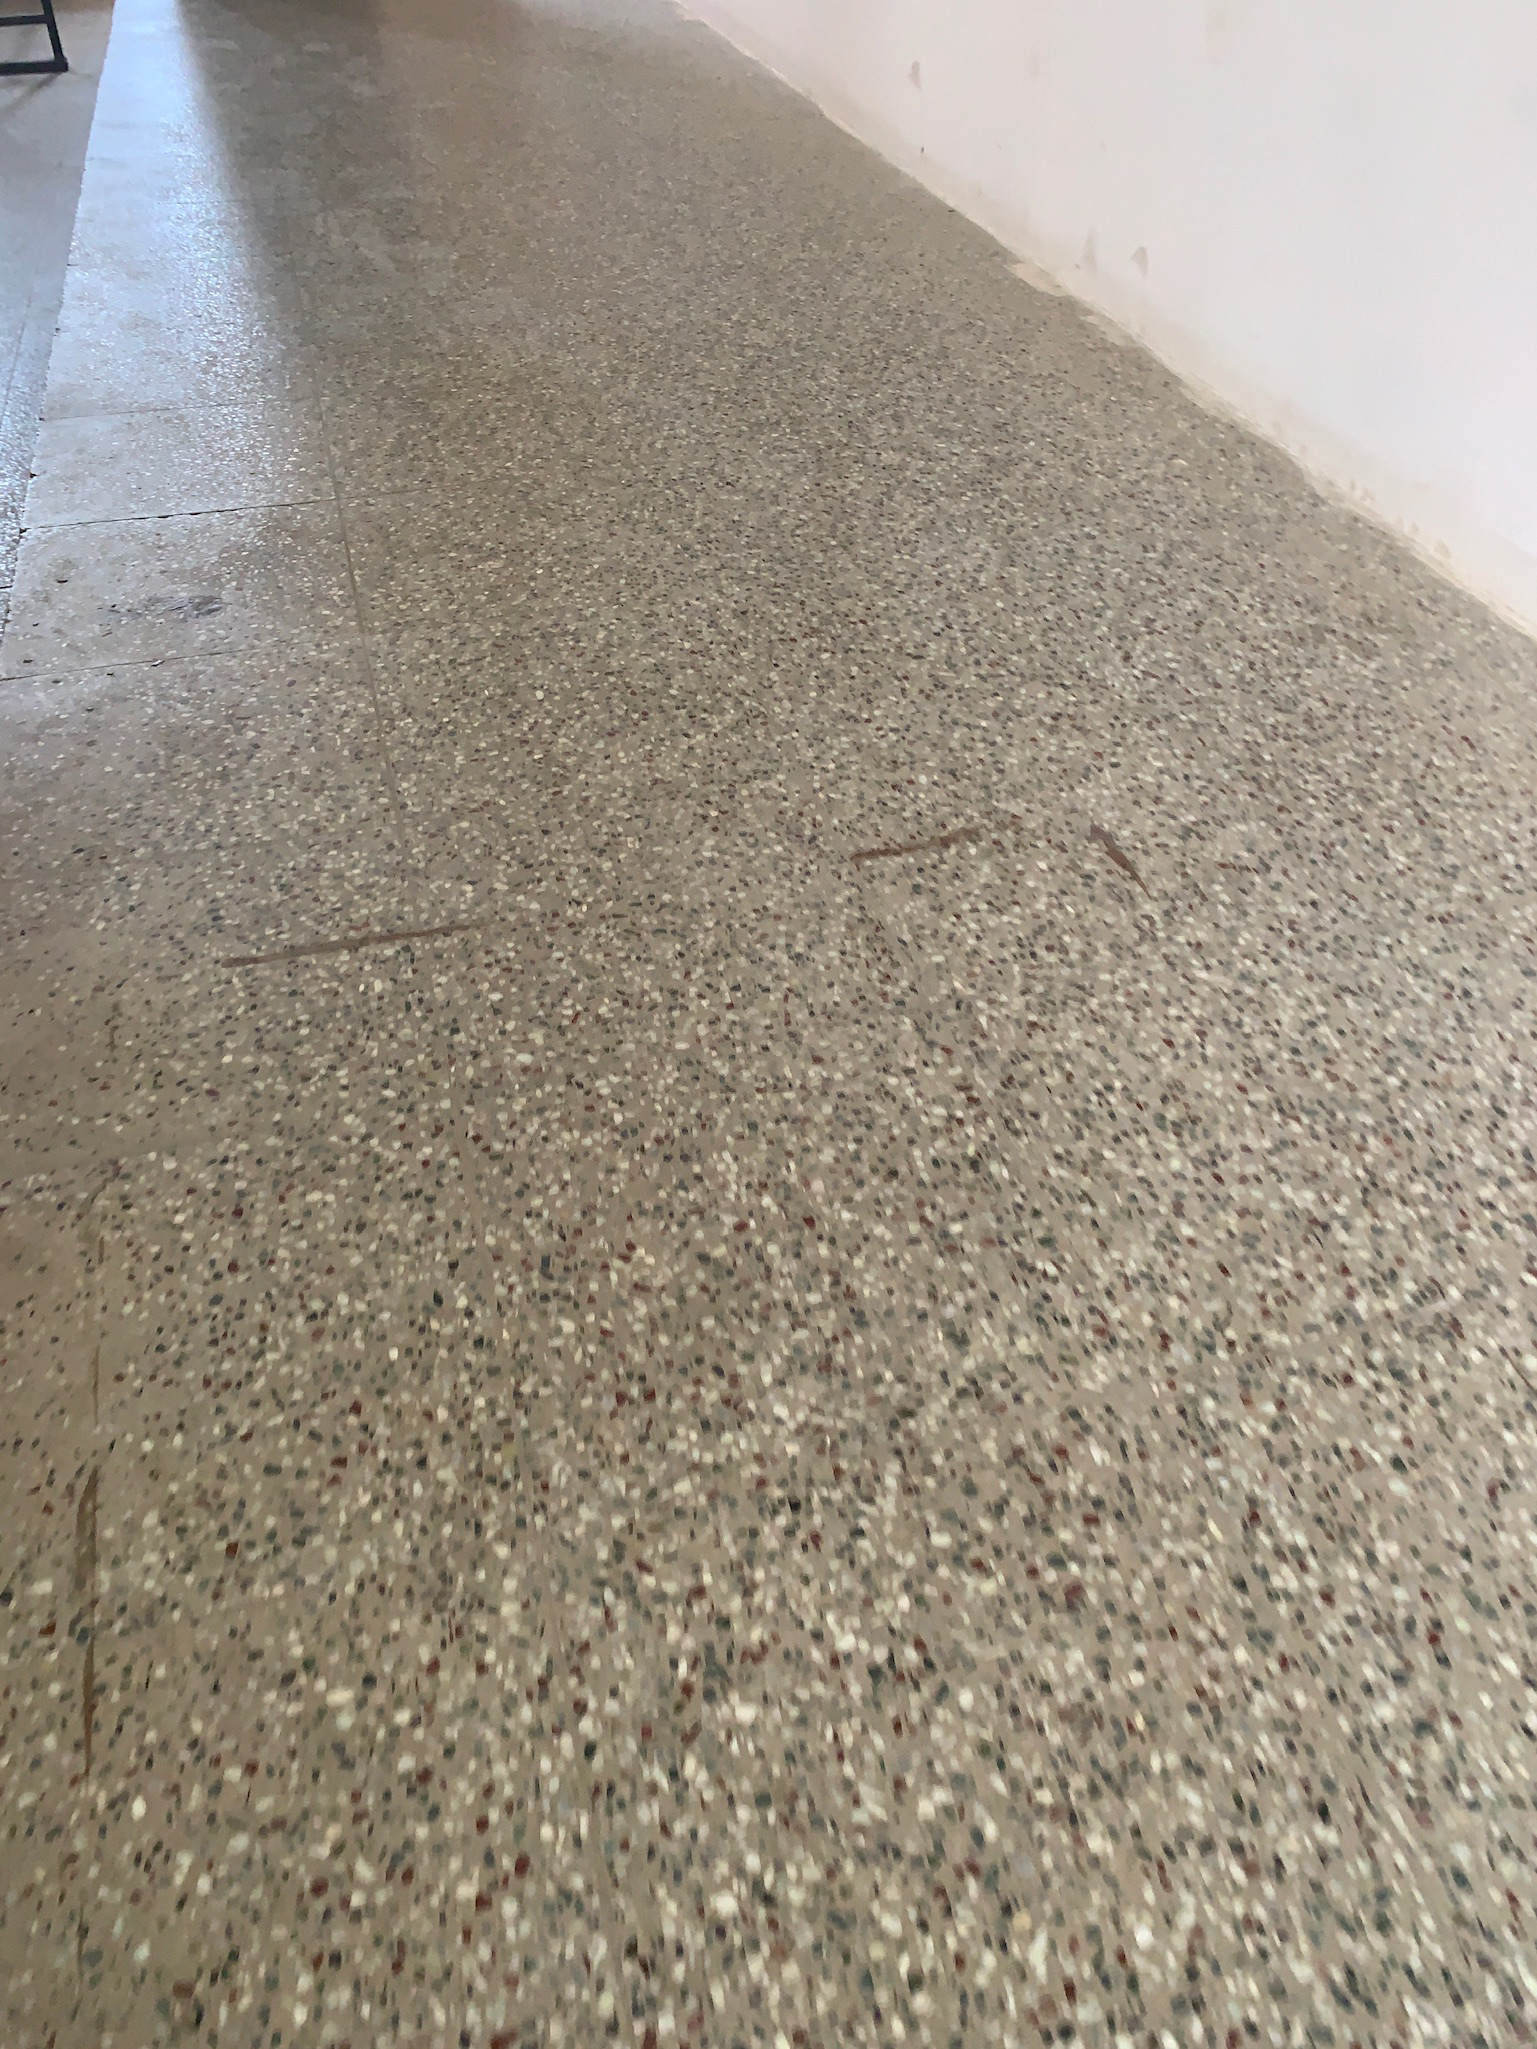

In [4]:
SEED = 123
random.seed(SEED)
rand_img = Image.open(random.choice(glob(DATASET_PATH + '/**/*')))

print('path:', rand_img.filename)
print('size:', rand_img.size)
print('mode:', rand_img.mode)
print('format:', rand_img.format)
display(rand_img)

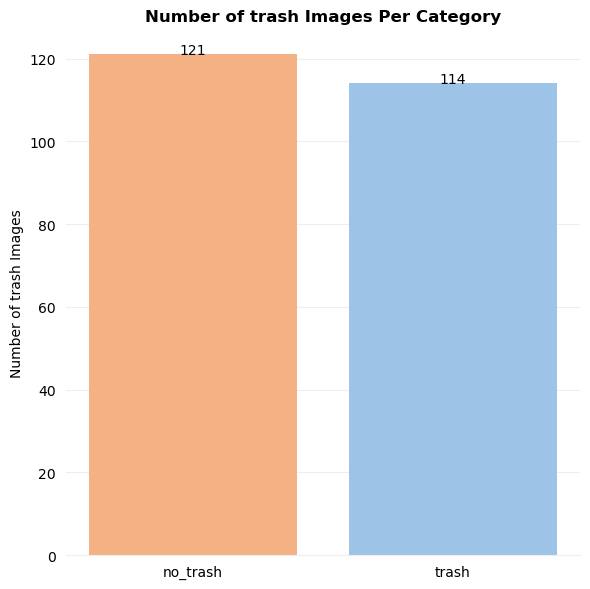

In [5]:
# Plot the number of images per subdirectory
x_coord = np.arange(len(dir_list))
colors = ['#f4b183', '#9dc3e6', '#a9d18e', '#ffd966']

fig, ax = plt.subplots(facecolor='white', figsize=(6,6))
ax.bar(x_coord, num_of_images, color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#EEEEEE')

ax.yaxis.grid(True, color='#EEEEEE')
ax.set_axisbelow(True)

plt.xticks(x_coord, dir_list)
ax.tick_params(bottom=False, left=False)

plt.title('Number of trash Images Per Category', fontweight='bold')
plt.ylabel('Number of trash Images')

for i in range(len(x_coord)):
    plt.text(i, num_of_images[i], num_of_images[i], ha='center')

plt.tight_layout()
plt.savefig('bar_chart.png', dpi=200)
plt.show()

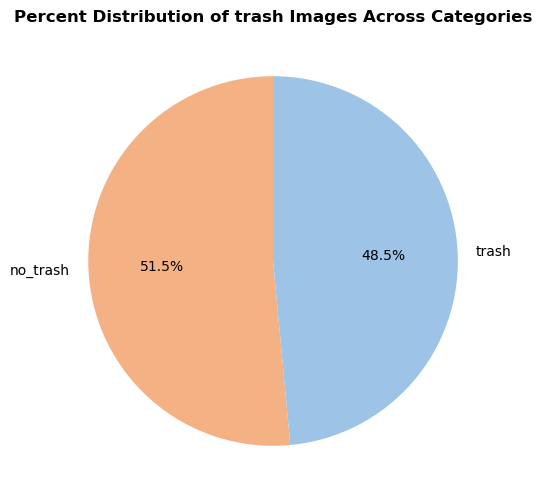

In [6]:
# Plot the percent distribution of images across subdirectories
plt.figure(facecolor='white', figsize=(6,6))
plt.pie(num_of_images,
        labels=dir_list,
        colors=colors,
        autopct='%.1f%%',
        startangle=90)
plt.title('Percent Distribution of trash Images Across Categories', fontweight='bold')
plt.savefig('pie_chart.png', dpi=200)
plt.show()

In [8]:
# Split the dataset folder into test, train, and val folders
OUTPUT_PATH = 'dataset_subsets'
if not os.path.exists(OUTPUT_PATH):
    splitfolders.ratio(DATASET_PATH, OUTPUT_PATH, SEED, (.7, .1, .2))

In [10]:
IMG_DIMS = 224
TARGET_SIZE = (IMG_DIMS, IMG_DIMS)
COLOR_MODE = 'rgb'
CLASS_MODE = 'categorical'
BATCH_SIZE = 32

In [11]:
# Take the path to the train folder and generate batches of data
TRAIN_PATH = os.path.join(OUTPUT_PATH, 'train')
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True)
train_gen = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    seed=SEED)

Found 163 images belonging to 2 classes.


In [12]:
# Take the path to the val folder and generate batches of data
VAL_PATH = os.path.join(OUTPUT_PATH, 'val')
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
val_gen = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    seed=SEED)

Found 23 images belonging to 2 classes.


In [13]:
# Take the path to the train folder and generate batches of data
TEST_PATH = os.path.join(OUTPUT_PATH, 'test')
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 49 images belonging to 2 classes.


In [14]:
print(train_gen.directory)
print(val_gen.directory)
print(test_gen.directory)

dataset_subsets\train
dataset_subsets\val
dataset_subsets\test


In [15]:
print(train_gen.class_indices)

{'no_trash': 0, 'trash': 1}


In [16]:
# Print the shapes of the first training batch tuple
images, labels = next(iter(train_gen))
print('images shape:', images.shape)  # (batch_size, *target_size, channels)
print('labels shape:', labels.shape)  # (batch_size, num_classes)

images shape: (32, 224, 224, 3)
labels shape: (32, 2)


In [17]:
# Instantiate a Densenet121 architecture without the fully-connected layer
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(IMG_DIMS, IMG_DIMS, 3)),
    input_shape=(IMG_DIMS, IMG_DIMS, 3))

29084464/29084464 [==============================] - 3s 0us/step


In [18]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Build the modified DenseNet121 model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (BatchN  (None, 50176)            200704    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [21]:
# Define hyperparameters
EPOCHS = 25
ETA = 0.0001

In [22]:
METRICS = ['categorical_accuracy', Precision(), Recall()]

In [23]:
# Compile the model
model.compile(optimizer=Adam(ETA),
              loss='categorical_crossentropy',
              metrics=METRICS)

In [24]:
# Create a learning rate scheduler callback
def scheduler(epoch):
    if epoch > 19:
        return ETA * 0.1
    else:
        return ETA
callback = LearningRateScheduler(scheduler)

In [26]:
# Estimate class weights for the unbalanced dataset
cls_wt = compute_class_weight(class_weight='balanced',
                              classes=np.unique(train_gen.labels),
                              y=train_gen.labels)
class_weight = {0: cls_wt[0], 1: cls_wt[1]}
print(class_weight)

{0: 0.9702380952380952, 1: 1.0316455696202531}


In [33]:
# Train the model
history = model.fit(train_gen,
                    epochs=EPOCHS,
                    callbacks=callback,
                    validation_data=val_gen,
                    class_weight=class_weight)

Epoch 1/25
6/6 [==============================] - 47s 7s/step - loss: 0.4913 - categorical_accuracy: 0.7730 - precision: 0.7730 - recall: 0.7730 - val_loss: 0.0435 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 2/25
6/6 [==============================] - 27s 4s/step - loss: 0.0669 - categorical_accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - val_loss: 0.0024 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 3/25
6/6 [==============================] - 27s 4s/step - loss: 0.0230 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.6213e-04 - val_categorical_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 4/25
6/6 [==============================] - 27s 5s/step - loss: 0.0187 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.5539e-04 - val_categorical_accuracy: 1.0000 - val_prec

In [34]:
def plot_metric_history(metric, val_metric, y_label, title):
    """
    Plots a training history metric.

    :param metric: the metric key
    :param val_metric: the validation metric key
    :param y_label: the y-axis label
    :param title: the title
    :return: None
    """
    plt.figure(facecolor='white', figsize=(8, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.ylabel(y_label)
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend(['training', 'validation'])
    plt.savefig(y_label + '.png', dpi=200)
    plt.show()

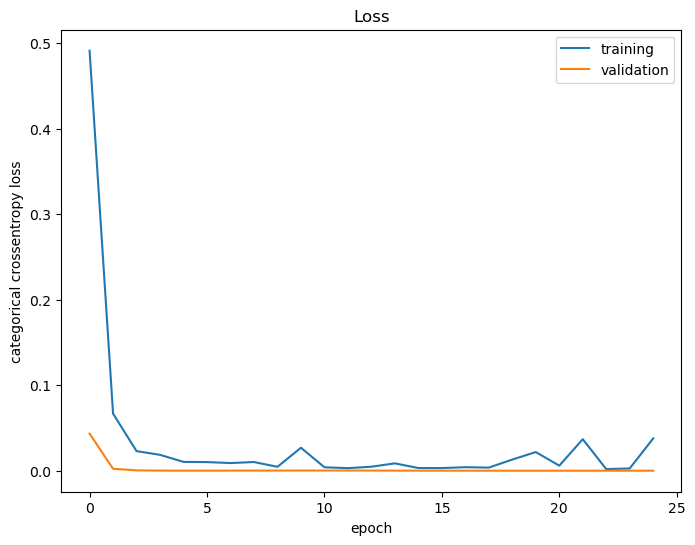

In [35]:
# Visualize loss history
plot_metric_history(metric='loss',
                    val_metric='val_loss',
                    y_label='categorical crossentropy loss',
                    title='Loss')

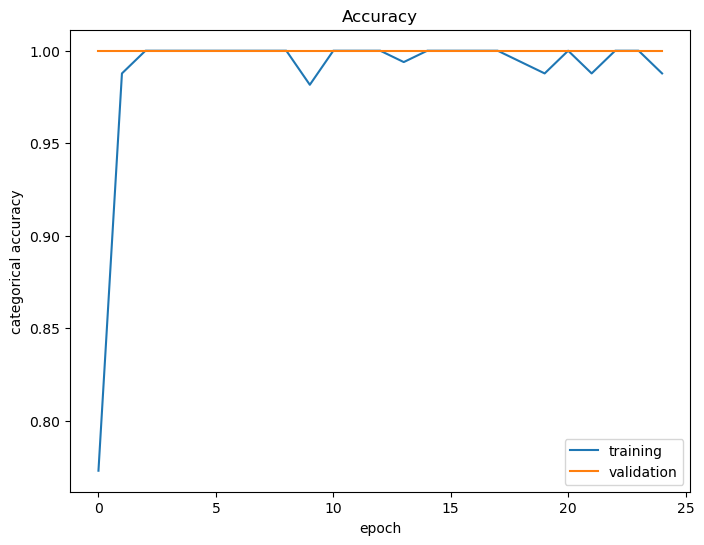

In [36]:
# Visualize accuracy history
plot_metric_history(metric='categorical_accuracy',
                    val_metric='val_categorical_accuracy',
                    y_label='categorical accuracy',
                    title='Accuracy')

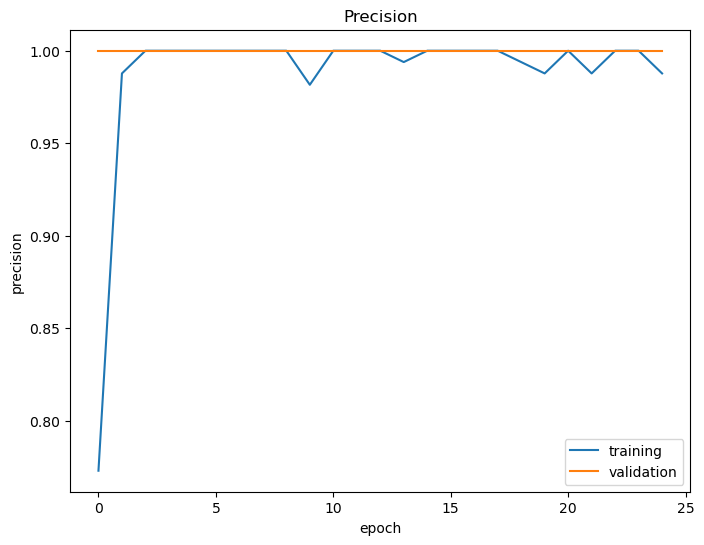

In [37]:
# Visualize precision history
plot_metric_history(metric='precision',
                    val_metric='val_precision',
                    y_label='precision',
                    title='Precision')

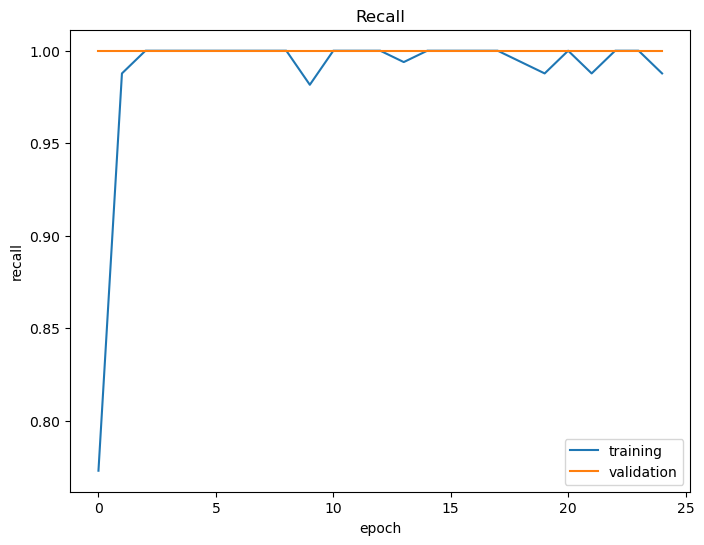

In [38]:
# Visualize recall history
plot_metric_history(metric='recall',
                    val_metric='val_recall',
                    y_label='recall',
                    title='Recall')

In [39]:
# Print metrics values for the model in test mode
result = model.evaluate(test_gen)
dict(zip(model.metrics_names, result))

2/2 [==============================] - 7s 2s/step - loss: 2.5281e-04 - categorical_accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


{'loss': 0.0002528068143874407,
 'categorical_accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0}

In [40]:
predictions = model.predict(test_gen)

2/2 [==============================] - 9s 1s/step


In [41]:
# Initialize true and predicted label values
y_true = test_gen.labels
y_pred = np.argmax(predictions, axis=1)

In [42]:
# Build a text report showing the main classification metrics
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        24

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49



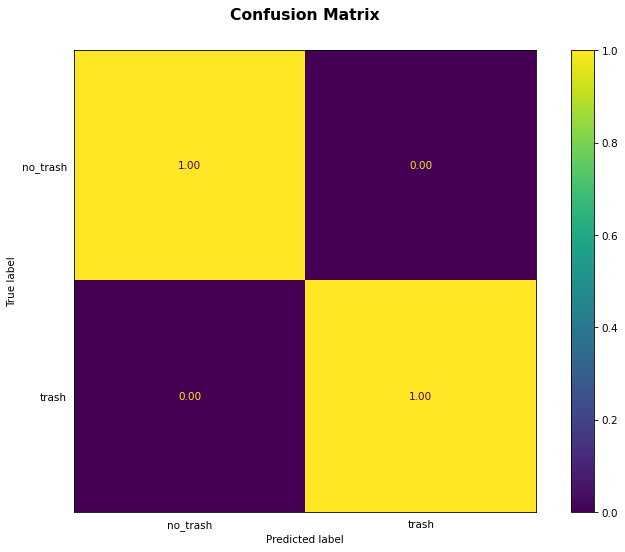

In [43]:
# Plot a confusion matrix given true and predicted labels
fig, ax = plt.subplots(facecolor='white', figsize=(12, 8), dpi=75)
fig = ConfusionMatrixDisplay.from_predictions(y_true,
                                              y_pred,
                                              display_labels=test_gen.class_indices,
                                              include_values=True,
                                              normalize='pred',
                                              values_format='.2f',
                                              cmap='viridis',
                                              ax=ax)
plt.tick_params(left=False, bottom=False)
plt.title('Confusion Matrix', fontsize=15, fontweight='bold', pad=30)
plt.savefig('confusion_matrix.png', dpi=200)
plt.show()

In [44]:
model.save_weights("densenet121.h5")

In [45]:
filepath="densenet121.hdf5"
model.save(filepath)

In [27]:
from tensorflow.keras.models import load_model
classifier = load_model('densenet121.hdf5')

In [48]:
def predict(image_path):
    from skimage import io
    from keras.preprocessing import image
    #path='imbalanced/Scratch/Scratch_400.jpg'
    import tensorflow as tf

    img = tf.keras.utils.load_img(image_path, grayscale=False, target_size=(224, 224))
    show_img=tf.keras.utils.load_img(image_path, grayscale=False, target_size=(224, 224))
    disease_class = ['no_trash','trash']
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    #x = np.array(x, 'float32')
    x /= 255

    custom = classifier.predict(x)
    print(custom[0])



    #x = x.reshape([64, 64]);

    #plt.gray()
    plt.imshow(show_img)
    plt.show()

    a=custom[0]
    ind=np.argmax(a)

    print('Prediction:',disease_class[ind])


In [50]:
predict('test/no_trash/IMG_1111 2.JPG')

1/1 [==============================] - 4s 4s/step
[9.9962163e-01 3.7834203e-04]


Prediction: no_trash


1/1 [==============================] - 0s 282ms/step
[0.02341218 0.97658783]


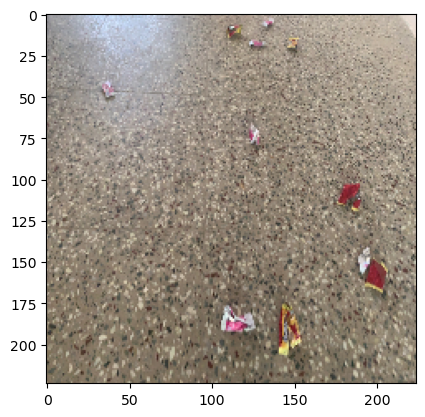

Prediction: trash


In [51]:
predict('test/trash/IMG_1243 2.JPG')